In [1]:
import tensorflow as tf
import numpy as np
import edward as ed
import matplotlib.pyplot as plt
# ed.set_seed(37)
# np.random.seed(37)

In [2]:
from edward.models import Bernoulli, Beta

def dirichlet_process(alpha):
    
  def cond(k, beta_k):
    flip = Bernoulli(p=beta_k)
    return tf.equal(flip, tf.constant(1))

  def body(k, beta_k):
    beta_k = beta_k * Beta(a=1.0, b=alpha)
    return k + 1, beta_k

  k = tf.constant(0)
  beta_k = Beta(a=1.0, b=alpha)
  stick_num, stick_beta = tf.while_loop(cond, body, loop_vars=[k, beta_k])
  return stick_num


dp = dirichlet_process(alpha=.1)

sess = tf.Session()
print(sess.run(dp))

0


In [3]:
c = lambda i, s: tf.less_equal(i, 7)
b = lambda i, s: (tf.add(i, 1), tf.add(s, i))
i = tf.constant(0)
s = tf.constant(0)
r = tf.while_loop(c, b, loop_vars=[i, s])
sess = tf.Session()
print(sess.run(r[1]))

28


In [4]:
from edward.models import Bernoulli, Beta, Normal


def dirichlet_process(alpha, base_cls, sample_n=50, *args, **kwargs):
  """Dirichlet process DP(``alpha``, ``base_cls(*args, **kwargs)``).

  Only works for scalar alpha and scalar base distribution.

  Parameters
  ----------
  alpha : tf.Tensor
    Concentration parameter. Its shape determines the batch shape of the DP.
  base_cls : RandomVariable
    Class of base distribution. Its shape (when instantiated)
    determines the event shape of the DP.
  sample_n : int, optional
    Number of samples for each DP in the batch shape.
  *args, **kwargs : optional
    Arguments passed into ``base_cls``.

  Returns
  -------
  tf.Tensor
    A ``tf.Tensor`` of shape ``[sample_n] + batch_shape + event_shape``,
    where ``sample_n`` is the number of samples for each DP,
    ``batch_shape`` is the number of independent DPs, and
    ``event_shape`` is the shape of the base distribution.
  """
  def cond(k, beta_k, draws, bools):
    # Proceed if at least one bool is True.
    return tf.reduce_any(bools)

  def body(k, beta_k, draws, bools):
    k = k + 1
    beta_k = beta_k * Beta(a=1.0, b=alpha)
    theta_k = base_cls(*args, **kwargs)

    # Assign ongoing samples to the new theta_k.
    indicator = tf.cast(bools, draws.dtype)
    new = indicator * theta_k
    draws = draws * (1.0 - indicator) + new

    flips = tf.cast(Bernoulli(p=beta_k), tf.bool)
    bools = tf.logical_and(flips, tf.equal(draws, theta_k))
    return k, beta_k, draws, bools

  k = 0
  beta_k = Beta(a=tf.ones(sample_n), b=alpha * tf.ones(sample_n))
  theta_k = base_cls(*args, **kwargs)

  # Initialize all samples as theta_k.
  draws = tf.ones(sample_n) * theta_k
  # Flip ``sample_n`` coins, one for each sample.
  flips = tf.cast(Bernoulli(p=beta_k), tf.bool)
  # Get boolean tensor for samples that return heads
  # and are currently equal to theta_k.
  bools = tf.logical_and(flips, tf.equal(draws, theta_k))

  total_sticks, _, samples, _ = tf.while_loop(
      cond, body, loop_vars=[k, beta_k, draws, bools])
  return total_sticks, samples


dp = dirichlet_process(0.1, Normal, mu=0.0, sigma=1.0)
sess = tf.Session()

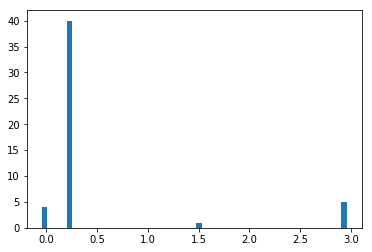

In [5]:
dpdraw = sess.run(dp)
unique, counts = np.unique(dpdraw[1], return_counts = True)
plt.bar(unique, counts, width=.05)
plt.show()

In [59]:
base_cls = Normal
alpha = tf.constant([.1, 1, 10])  # Have 3 Dirichlet processes
logits = tf.zeros(shape=alpha.shape)
stickbreaks = tf.zeros(alpha.shape)

def sample():
    """Sample one item from the draw from the Dirichlet process."""
    p = tf.random_uniform(alpha.shape)
    
    def cond(s):
        # Proceed if any p is greater than all s
        return tf.reduce_any(p.greater(s))

    def body(s):
        beta = Beta(a=1.0 * tf.ones(alpha.shape), b=alpha)
        
        # Take proportion of remaining stick
        lastps = s[-1]  # use correct indexing here
        remainders = tf.ones((,)) - lastps
        s.concat(s, lastps + remainders * beta)

        # Assign ongoing samples to the new theta_k.
        theta = base_cls(*args, **kwargs)
        indicator = tf.cast(bools, draws.dtype)
        new = indicator * theta_k
        draws = draws * (1.0 - indicator) + new

        flips = tf.cast(Bernoulli(p=beta_k), tf.bool)
        bools = tf.logical_and(flips, tf.equal(draws, theta_k))
        return k, beta_k, draws, bools

    total_sticks, _, samples, _ = tf.while_loop(
      cond, body, loop_vars=[k, beta_k, draws, bools])

def pmax(a):
    aflat = tf.reshape(a, [-1])
    idx = tf.reshape(tf.argmax(aflat, 0), [1,])
    print(idx)
    return aflat, idx, aflat[idx]
    amax = aflat[tf.cast(idx, tf.int64)]
    return aflat

sess = tf.Session()
# draw = sess.run(sample())
# print(draw)
sess.run(pmax(tf.random_uniform([3])))

Tensor("Reshape_24:0", shape=(1,), dtype=int64)


TypeError: Input 'strides' of 'StridedSlice' Op has type int32 that does not match type int64 of argument 'begin'.

In [126]:
from edward.models import RandomVariable, Categorical, Mixture, MultivariateNormalDiag
from tensorflow.contrib.distributions import Distribution
from tensorflow.contrib.distributions.python.ops import distribution_util

class DirichletProcessSB(RandomVariable, Distribution):
    """A Dirichlet process implemented using a stick-breaking construction.
    
    Each sample/value is a `Mixture` distribution.
    """
    
    def __init__(self, alpha = tf.ones([1])):
        self.alpha = alpha
        super(DirichletProcessSB, self).__init__(
            dtype = None,  # No type enforcement
            is_continuous = False,
            is_reparameterized = False,
            validate_args = False,
            allow_nan_stats = True,
            parameters = {alpha: self.alpha},
            name = 'DP')

    @distribution_util.AppendDocstring("Some other details.")
    def _log_prob(self, value):
        raise NotImplementedError("log_prob is not implemented")

    @distribution_util.AppendDocstring("Some other details.")
    def _sample_n(self, n, seed=None):
        if seed is not None:
            raise ValueError('Do not know how to use specified seed')
        print(n)
        K = 3
        cat = Categorical(logits=tf.zeros([n, K]))
        components = [
            MultivariateNormalDiag(
                mu = tf.ones([n, 1]) * (k + 10),
                diag_stdev = tf.ones([n, 1]))
            for k in range(K)]
        return Mixture(cat=cat, components=components)
    
    def __repr__(self):
        return '<DirichletProcessSB: {}>'.format(id(self))

pi = DirichletProcessSB()
pi
sess = tf.Session()
sess.run(pi._sample_n(10))

1
10


array([[ 11.23747063],
       [  9.15561962],
       [  9.43934631],
       [  8.49564362],
       [  8.63346863],
       [ 12.43154335],
       [ 13.26533985],
       [ 12.11446762],
       [  8.77148151],
       [ 11.06395149]], dtype=float32)

In [173]:
from edward.models import Categorical

def stick_breaking_prior(beta, )

class StickBreakingPrior(object):
    
    def __init__(self, a, b):
        self.beta = Beta(a, b)

        # The stick breaking proportions sampled so far
        self.betaprime = tf.zeros(shape = (0,), dtype=tf.float32)  # Initialise to empty tensor

        # The logits for each broken part of stick and remainder,
        self.logits = tf.zeros(shape = (1,))  # Initialise just representing remainder

        # The amount of stick remaining
        self.remaining = tf.ones((1,))  # Initialise to one

    def _new_component(self):
        # Sample a new betaprime
        thisbetaprime = self.beta.sample()
        self.betaprime = tf.concat((self.betaprime, thisbetaprime), 0)
        
        # Recalculate logits
        newremainder = self.remaining * (1. - thisbetaprime)
        compsize = self.remaining * thisbetaprime
        self.logits[-1] = self.log(newremainder)
        self.logits = tf.concat((self.logits, tf.ones(()) * tf.log(compsize)), 0)
        
        return self._num_components()
    
    def _num_components(self):
        return self.logits.shape[0] - 1
        
    def sample(self):
        # Sample another broken part or remainder
        choice = Categorical(logits = self.logits).sample()

        # Did we sample an existing component or do we need to break some
        # more stick?
        comp = tf.cond(
            tf.equal(self._num_components(), choice), 
            self._new_component,
            lambda: choice - 1)  # Take one off as logits for remainder of stick are first
        
stick = StickBreakingPrior(tf.ones(()), tf.ones(()))        

sess.run(stick.sample())

(0,)
()


ValueError: Shape must be rank 1 but is rank 0 for 'cond_6/concat' (op: 'ConcatV2') with input shapes: [0], [], [].

In [4]:
empty = tf.zeros(shape = (3,))
scalar = tf.ones((2,))
concatd = tf.concat((empty, scalar), 0)
sess = tf.Session()
sess.run(concatd)

array([ 0.,  0.,  0.,  1.,  1.], dtype=float32)